<a href="https://colab.research.google.com/github/ptl-harsh/QLab_Task/blob/main/P1T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multivariate Time series Imputation using Transformer Encoder :

In [ ]:
#@title Step 1: Install and Import Required Libraries

# Install wandb if not already installed.
!pip install wandb

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb

# Set random seeds for reproducibility.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the CSV file (assuming it's named "exchange_rate.csv")
data_path = "/content/iisc-intern-task/exchange_rate.csv"  # Change this if needed

# Read the CSV with comma separator
df = pd.read_csv(data_path, sep=",")

# Print first few rows to check
print("First few rows:\n", df.head())

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d %H:%M")

# Sort data by date
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop the 'date' column and use the rest as features
data = df.drop(columns=["date"]).values.astype(np.float32)

# Normalize the data (feature-wise)
scaler = StandardScaler()
data = scaler.fit_transform(data)

print("Processed Data Shape:", data.shape)
print("First row (normalized):", data[0])


First few rows:
             date       0       1         2         3         4         5  \
0  1990/1/1 0:00  0.7855  1.6110  0.861698  0.634196  0.211242  0.006838   
1  1990/1/2 0:00  0.7818  1.6100  0.861104  0.633513  0.211242  0.006863   
2  1990/1/3 0:00  0.7867  1.6293  0.861030  0.648508  0.211242  0.006975   
3  1990/1/4 0:00  0.7860  1.6370  0.862069  0.650618  0.211242  0.006953   
4  1990/1/5 0:00  0.7849  1.6530  0.861995  0.656254  0.211242  0.006940   

          6      OT  
0  0.525486  0.5930  
1  0.523972  0.5940  
2  0.526316  0.5973  
3  0.523834  0.5970  
4  0.527426  0.5985  
Processed Data Shape: (7588, 8)
First row (normalized): [ 0.06241314 -0.143034    0.3405796  -1.2670058   2.8509977  -1.7183161
 -1.7407598  -0.5327487 ]


In [ ]:
#@title Step 3: Create Dataset for Sequence Generation and Random Masking

class TimeSeriesImputationDataset(Dataset):
    def __init__(self, data, seq_len=96, mask_ratio=0.25):
        """
        data: numpy array of shape (num_timesteps, num_features)
        seq_len: length of each sequence
        mask_ratio: fraction of entries to mask randomly in each sequence.
        """
        self.seq_len = seq_len
        self.mask_ratio = mask_ratio

        # Create overlapping sequences from the data.
        self.sequences = []
        for i in range(len(data) - seq_len + 1):
            self.sequences.append(data[i:i+seq_len])
        self.sequences = np.array(self.sequences)  # shape: (num_samples, seq_len, num_features)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get original sequence and create a copy for masking.
        seq = self.sequences[idx]
        # Create a mask for the sequence (True where values are masked)
        mask = np.random.rand(*seq.shape) < self.mask_ratio
        # Create the input sequence by replacing masked positions with 0.
        seq_masked = seq.copy()
        seq_masked[mask] = 0.0

        # Convert to torch tensors.
        seq_masked = torch.tensor(seq_masked, dtype=torch.float32)
        seq = torch.tensor(seq, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.bool)
        return seq_masked, seq, mask

# Example: Create a dataset with sequence length 96 and mask ratio of 25%
dataset = TimeSeriesImputationDataset(data, seq_len=96, mask_ratio=0.25)
print("Dataset samples:", len(dataset))


Dataset samples: 7493


In [ ]:
#@title Step 4: Define the Transformer Encoder Imputation Model

class TransformerImputer(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        """
        feature_dim: number of features in the input.
        d_model: embedding dimension.
        nhead: number of heads in multi-head attention.
        num_layers: number of transformer encoder layers.
        """
        super(TransformerImputer, self).__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, feature_dim)

    def forward(self, x):
        # x shape: (batch, seq_len, feature_dim)
        x_emb = self.input_proj(x)  # (batch, seq_len, d_model)
        # TransformerEncoder (with batch_first=True) accepts (batch, seq_len, d_model)
        encoded = self.transformer_encoder(x_emb)
        out = self.output_proj(encoded)  # (batch, seq_len, feature_dim)
        return out

# Initialize model
feature_dim = data.shape[1]
model = TransformerImputer(feature_dim=feature_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1)
print(model)


TransformerImputer(
  (input_proj): Linear(in_features=8, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=64, out_features=8, bias=True)
)


In [ ]:
#@title Step 5: Define Training and Evaluation Functions

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    for seq_masked, seq_orig, mask in dataloader:
        seq_masked = seq_masked.to(device)
        seq_orig = seq_orig.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        output = model(seq_masked)
        # Calculate loss only for the masked positions.
        loss = criterion(output[mask], seq_orig[mask])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    count = 0
    with torch.no_grad():
        for seq_masked, seq_orig, mask in dataloader:
            seq_masked = seq_masked.to(device)
            seq_orig = seq_orig.to(device)
            mask = mask.to(device)

            output = model(seq_masked)
            mse_loss = criterion(output[mask], seq_orig[mask]).item()
            mae_loss = nn.L1Loss()(output[mask], seq_orig[mask]).item()
            total_loss += mse_loss
            total_mae += mae_loss
            count += 1
    return total_loss / count, total_mae / count


In [ ]:
#@title Step 6: Train the Model for Different Mask Ratios using Weights & Biases

# Define training hyperparameters.
num_epochs = 10       # Adjust epochs as needed.
batch_size = 64
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# List of mask ratios to try.
mask_ratios = [0.125, 0.25, 0.375, 0.5]

# Dictionary to store evaluation results for visualization.
results = {}

for ratio in mask_ratios:
    print(f"\nTraining for mask ratio: {ratio}")

    # Initialize a new wandb run for each mask ratio.
    wandb.init(project="QLabIntern2025_Imputation",
               name=f"Transformer_Imputation_mask_{int(ratio*100)}",
               config={"mask_ratio": ratio, "epochs": num_epochs, "batch_size": batch_size, "learning_rate": learning_rate})

    # Create dataset and dataloaders for current mask ratio.
    train_dataset = TimeSeriesImputationDataset(data, seq_len=96, mask_ratio=ratio)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # For simplicity, using same data for validation

    # Initialize model (fresh for each ratio) and optimizer.
    model = TransformerImputer(feature_dim=feature_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    epoch_losses = []
    epoch_mae = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_mse, val_mae = evaluate(model, val_loader, criterion, device)
        epoch_losses.append(val_mse)
        epoch_mae.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} - Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

        # Log metrics to wandb.
        wandb.log({"epoch": epoch+1, "Val_MSE": val_mse, "Val_MAE": val_mae})

    # Save results for visualization later.
    results[ratio] = {"mse": epoch_losses, "mae": epoch_mae}

    # Optionally, save the model checkpoint.
    wandb.save("model.pt")
    wandb.finish()


Using device: cpu

Training for mask ratio: 0.125


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hvpatel-me (hvpatel-me-nit-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10 - Val MSE: 0.0280, Val MAE: 0.1216
Epoch 2/10 - Val MSE: 0.0214, Val MAE: 0.1024
Epoch 3/10 - Val MSE: 0.0196, Val MAE: 0.0983
Epoch 4/10 - Val MSE: 0.0165, Val MAE: 0.0896
Epoch 5/10 - Val MSE: 0.0158, Val MAE: 0.0876
Epoch 6/10 - Val MSE: 0.0156, Val MAE: 0.0887
Epoch 7/10 - Val MSE: 0.0143, Val MAE: 0.0830
Epoch 8/10 - Val MSE: 0.0144, Val MAE: 0.0852
Epoch 9/10 - Val MSE: 0.0131, Val MAE: 0.0810
Epoch 10/10 - Val MSE: 0.0119, Val MAE: 0.0769


Val_MAE,█▅▄▃▃▃▂▂▂▁
Val_MSE,█▅▄▃▃▃▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Val_MAE,0.07694
Val_MSE,0.01191
epoch,10



Training for mask ratio: 0.25


Epoch 1/10 - Val MSE: 0.0288, Val MAE: 0.1205
Epoch 2/10 - Val MSE: 0.0233, Val MAE: 0.1070
Epoch 3/10 - Val MSE: 0.0218, Val MAE: 0.1040
Epoch 4/10 - Val MSE: 0.0216, Val MAE: 0.1061
Epoch 5/10 - Val MSE: 0.0180, Val MAE: 0.0936
Epoch 6/10 - Val MSE: 0.0178, Val MAE: 0.0933
Epoch 7/10 - Val MSE: 0.0173, Val MAE: 0.0941
Epoch 8/10 - Val MSE: 0.0145, Val MAE: 0.0833
Epoch 9/10 - Val MSE: 0.0138, Val MAE: 0.0818
Epoch 10/10 - Val MSE: 0.0151, Val MAE: 0.0864


Val_MAE,█▆▅▅▃▃▃▁▁▂
Val_MSE,█▅▅▅▃▃▃▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Val_MAE,0.08635
Val_MSE,0.01506
epoch,10



Training for mask ratio: 0.375


Epoch 1/10 - Val MSE: 0.0307, Val MAE: 0.1256
Epoch 2/10 - Val MSE: 0.0265, Val MAE: 0.1153
Epoch 3/10 - Val MSE: 0.0231, Val MAE: 0.1063
Epoch 4/10 - Val MSE: 0.0244, Val MAE: 0.1101
Epoch 5/10 - Val MSE: 0.0203, Val MAE: 0.0989
Epoch 6/10 - Val MSE: 0.0228, Val MAE: 0.1081
Epoch 7/10 - Val MSE: 0.0188, Val MAE: 0.0958
Epoch 8/10 - Val MSE: 0.0176, Val MAE: 0.0915
Epoch 9/10 - Val MSE: 0.0168, Val MAE: 0.0895
Epoch 10/10 - Val MSE: 0.0168, Val MAE: 0.0901


Val_MAE,█▆▄▅▃▅▂▁▁▁
Val_MSE,█▆▄▅▃▄▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Val_MAE,0.09014
Val_MSE,0.01679
epoch,10



Training for mask ratio: 0.5


Epoch 1/10 - Val MSE: 0.0358, Val MAE: 0.1377
Epoch 2/10 - Val MSE: 0.0336, Val MAE: 0.1321
Epoch 3/10 - Val MSE: 0.0277, Val MAE: 0.1172
Epoch 4/10 - Val MSE: 0.0252, Val MAE: 0.1109
Epoch 5/10 - Val MSE: 0.0226, Val MAE: 0.1044
Epoch 6/10 - Val MSE: 0.0214, Val MAE: 0.1013
Epoch 7/10 - Val MSE: 0.0208, Val MAE: 0.1003
Epoch 8/10 - Val MSE: 0.0198, Val MAE: 0.0973
Epoch 9/10 - Val MSE: 0.0198, Val MAE: 0.0973
Epoch 10/10 - Val MSE: 0.0216, Val MAE: 0.1031


Val_MAE,█▇▄▃▂▂▂▁▁▂
Val_MSE,█▇▄▃▂▂▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Val_MAE,0.10309
Val_MSE,0.02156
epoch,10


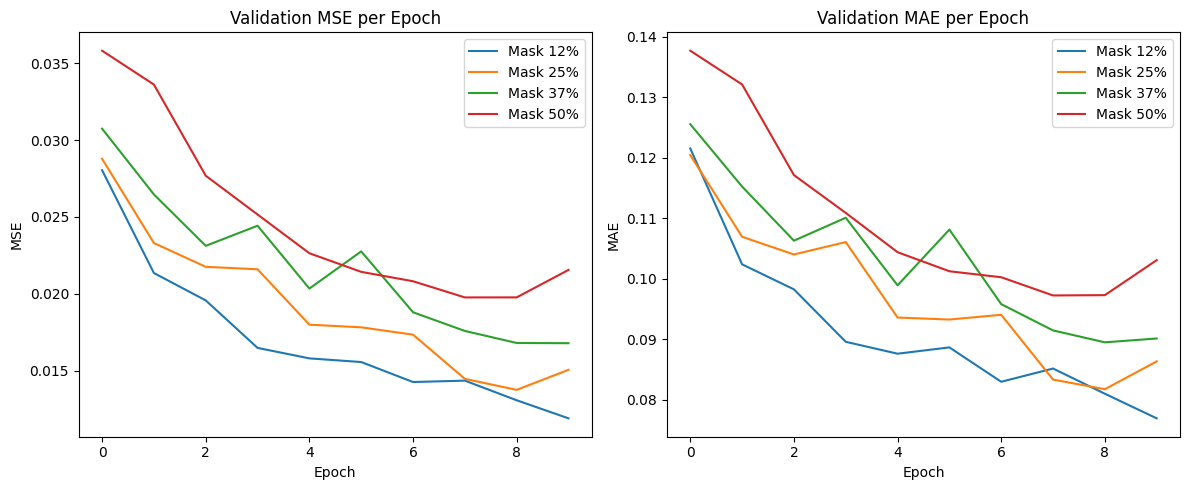

In [16]:
#@title Step 7: Visualize the Evaluation Metrics

plt.figure(figsize=(12, 5))

# Plot MSE for each mask ratio.
plt.subplot(1, 2, 1)
for ratio in mask_ratios:
    plt.plot(results[ratio]["mse"], label=f"Mask {int(ratio*100)}%")
plt.title("Validation MSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# Plot MAE for each mask ratio.
plt.subplot(1, 2, 2)
for ratio in mask_ratios:
    plt.plot(results[ratio]["mae"], label=f"Mask {int(ratio*100)}%")
plt.title("Validation MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()
